In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpyro as npy
import numpyro.distributions as dist
import chainconsumer as cc
import zodiax as zdx
import alphacen as ac
import utils

import os
os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'monospace'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


In [7]:
param_list = ['sep', 'pa', 'logF', 'cont']
initial_values = [5, 1, 6.8, 3.37]

class Model(zdx.Base):
    sep : float
    pa : float
    logF : float
    cont : float
    source : object

    def __init__(self, sep=5, pa=1.5, logF=7, cont=3.37, source=None):
        self.sep = sep
        self.pa = pa
        self.logF = logF
        self.cont = cont
        self.source = source

    def model(self, source):

        psf_obj = source
        psf_obj.sep = self.sep
        psf_obj.pa = jnp.rad2deg(self.pa)
        psf_obj.flux = 10 ** self.logF
        psf_obj.cont = self.cont

        optics, source = psf_obj.GetInstrument()
        image = optics.model(source)

        return image

source = ac.AlphaCenPSF(mask_dir='data/toliman_pupil.npy', n_wavels=3)

In [8]:
print(Model().set('sep',1.0))

Model(sep=1.0, pa=1.5, logF=7, cont=3.37)


Model(sep=5, pa=1, logF=6.8, cont=3.37)


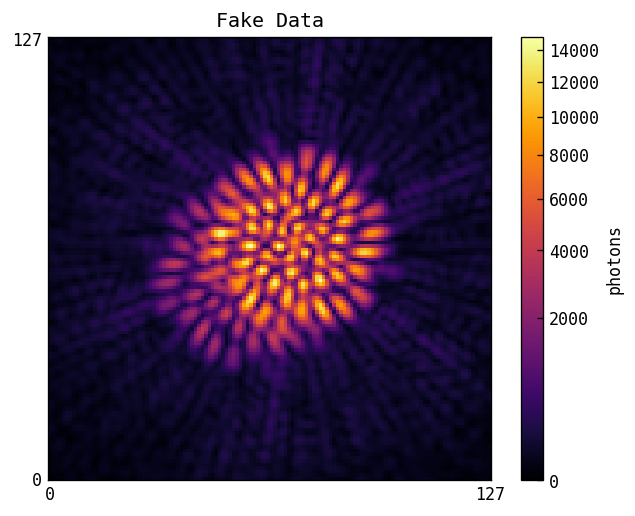

In [9]:

data = Model(*initial_values).model(source)
print(Model(*initial_values))
utils.PlotSqrtPSF(data, title='Fake Data')

In [5]:
def sampling_fn(data, model):

    paths = ['sep', 'pa', 'logF', 'cont']

    # Define priors
    values = [npy.sample('sep', dist.Uniform(0, 15)),
              npy.sample('pa', dist.Uniform(0, 2*jnp.pi)),
              npy.sample('logF', dist.Uniform(6, 8.5)),
              npy.sample('cont', dist.Uniform(1, 10)),
              # npy.sample('rad', dist.Uniform(0, 5)),
              # npy.sample('ang', dist.Uniform(0, 2*jnp.pi))
              ]

    # scale = npy.sample("scale", dist.HalfNormal(1))

    # Sample from the posterior distribution
    data = data.flatten()
    with npy.plate("data", len(data)):
        # with npy.plate("scale", len(data)):
        # model_sampler = dist.Normal(
        #     model.set(paths, values).model().flatten(), scale=scale)
        model_sampler = dist.Normal(
            model.set(paths, values).model().flatten(), scale=0.2)
        return npy.sample("Sampler", model_sampler, obs=data)

In [6]:
sampler = npy.infer.MCMC(
    npy.infer.NUTS(sampling_fn),
    num_warmup=5000,
    num_samples=5000,
)

model_instance =
sampler.run(jr.PRNGKey(0), data, Model(), init_params={"sep": 2, "pa": 2, "logF": 6, "cont": 2})

sampler.print_summary()
values_out = sampler.get_samples()

  0%|          | 0/10000 [00:00<?, ?it/s]


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=3/0)>
The problem arose with the `bool` function. 
The error occurred while tracing the function _body_fn at /Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd/venv-fmpb/lib/python3.10/site-packages/numpyro/infer/hmc_util.py:1001 for while_loop. This value became a tracer due to JAX operations on these lines:

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd/venv-fmpb/lib/python3.10/site-packages/dLux/sources.py:413 (get_flux)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd/venv-fmpb/lib/python3.10/site-packages/dLux/sources.py:413 (get_flux)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd/venv-fmpb/lib/python3.10/site-packages/dLux/utils/models.py:58 (simple_optical_system)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd/venv-fmpb/lib/python3.10/site-packages/dLux/utils/models.py:78 (simple_optical_system)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd/venv-fmpb/lib/python3.10/site-packages/dLux/apertures.py:3714 (__new__)

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [19]:
values_out

{'$b$': Array([-1.0321069, -1.1029315, -1.081233 , ..., -1.0097104, -1.1218822,
        -1.1108398], dtype=float32),
 '$m$': Array([1.9891518, 2.0148504, 2.1299367, ..., 2.0785165, 2.0042598,
        2.0396762], dtype=float32)}

In [20]:
model

Model(m=2, b=-1)

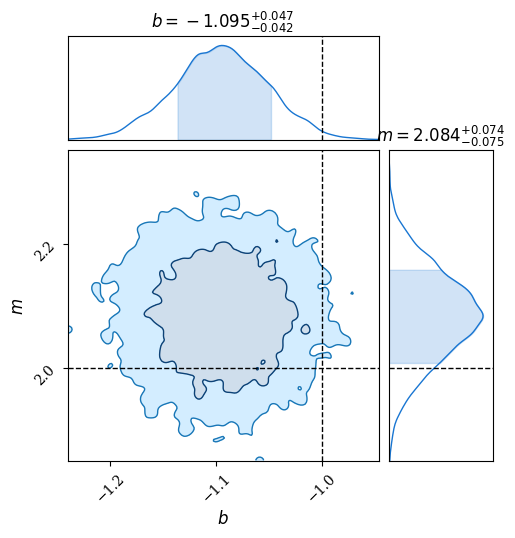

In [21]:
chain = cc.ChainConsumer()
chain.add_chain(values_out)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = chain.plotter.plot(truth={"$m$": 2, "$b$": -1, 'scale': 0.2})
fig.set_size_inches((5,5))

In [22]:
test_model = model.set(['m', 'b'], [values_out['$m$'].mean(), values_out['$b$'].mean()])

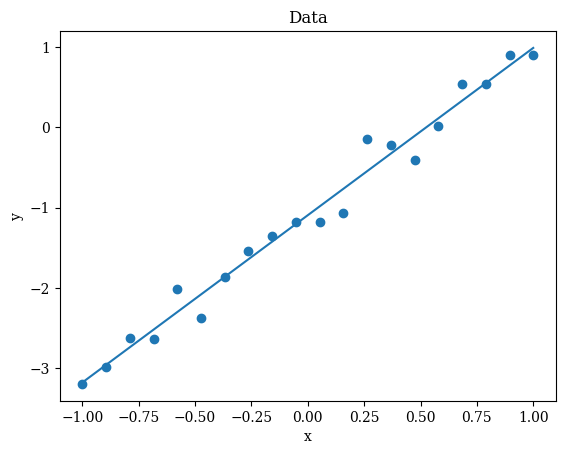

In [23]:
fig, ax = plt.subplots()
ax.scatter(data_x, data_y)
ax.plot(data_x, test_model.model())
ax.set(
    xlabel="x",
    ylabel="y",
    title="Data"
)
plt.show()
